In [34]:
from src.classifier import load_full_model
from src.utils import load_cleaned_data, metrics, plot_confusion_matrix
import numpy as np
import pandas as pd
from textblob import TextBlob


# Load saved pipeline components
model, vectorizer, scaler, metadata = load_full_model(output_dir="models", name="best_rf_model")


 Loaded model, vectorizer, scaler, and metadata from models/


2. Load and transform by-publisher test data

In [35]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']  # Ranges from -1 to 1

In [32]:
# Load the same by-publisher test set
test_data = load_cleaned_data("data/preprocessed/bypublisher_clean.tsv")

test_data['sentiment_score'] = test_data['full_text'].apply(vader_sentiment)

def extract_style_features(df):
    df["word_count"] = df["full_text"].apply(lambda x: len(str(x).split()))
    df["subjectivity"] = df["full_text"].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    df["polarity"] = df["full_text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df["lexical_diversity"] = df["full_text"].apply(lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1e-5))
    df["question_marks"] = df["full_text"].apply(lambda x: str(x).count('?'))
    return df

# Recompute them
test_data = extract_style_features(test_data)


# Extract raw inputs and labels
X_text = test_data["full_text"]
y_test = test_data["label"]
style_features = test_data[metadata["features"]["style"]]

# Transform using TF-IDF vectorizer
X_vectorized = vectorizer.transform(X_text)

# Scale stylistic features
X_style_scaled = scaler.transform(style_features)

# Combine
from scipy.sparse import hstack
X_test_combined = hstack([X_vectorized, X_style_scaled])


3. Predict and evaluate

Accuracy: 0.51
Balanced Accuracy: 0.51
Precision: 0.52
Recall: 0.31
F1: 0.39
AUC: 0.54


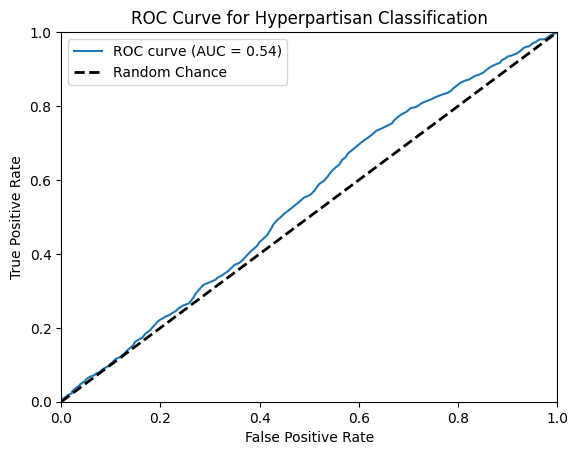

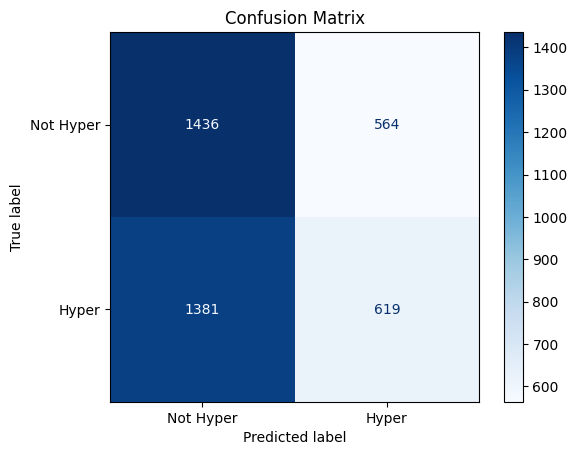

In [33]:
# Predict
y_pred = model.predict(X_test_combined)
y_pred_proba = model.predict_proba(X_test_combined)[:, 1]

# Evaluate
metrics(y_test, y_pred, y_pred_proba)
plot_confusion_matrix(y_test, y_pred)


# Evaluation

In [37]:
from collections import defaultdict
import numpy as np
import pandas as pd

MIN_ARTICLE_COUNT = 10

# Set up
domain_stats = defaultdict(lambda: {
    'count': 0,
    'labels': set(),
    'pred_hyper_count': 0,
    'sentiment_sum': 0.0,
    'original_indices': []
})

# Build domain-level stats
for idx, row in test_data.iterrows():
    domain = row['domain']
    label = row['label']
    sentiment = row['sentiment_score']

    domain_stats[domain]['count'] += 1
    domain_stats[domain]['labels'].add(label)
    domain_stats[domain]['original_indices'].append(idx)
    domain_stats[domain]['sentiment_sum'] += abs(sentiment)

    if y_pred[idx] == 1:
        domain_stats[domain]['pred_hyper_count'] += 1

# Filter consistent domains
consistent_domains = []
for domain, stats in domain_stats.items():
    if len(stats['labels']) == 1:
        label = list(stats['labels'])[0]
        perc_hyper = stats['pred_hyper_count'] / stats['count'] * 100
        avg_conf = np.mean([y_pred_proba[i] for i in stats['original_indices']])
        avg_sent = stats['sentiment_sum'] / stats['count']

        consistent_domains.append({
            'domain': domain,
            'label': label,
            'article_count': stats['count'],
            'pred_hyper_count': stats['pred_hyper_count'],
            'percentage_hyper': perc_hyper,
            'avg_confidence': avg_conf,
            'avg_sentiment': avg_sent
        })

consistent_df = pd.DataFrame(consistent_domains)
consistent_df.to_csv("results/publisher_analysis_rf.csv", index=False)

# Summary stats
num_consistent = len(consistent_df)
num_inconsistent = len(domain_stats) - num_consistent
print(f"Consistent publishers: {num_consistent}")
print(f"Inconsistent publishers: {num_inconsistent}")

# Label breakdown
hyper_pubs = consistent_df[consistent_df['label'] == 1]
non_hyper_pubs = consistent_df[consistent_df['label'] == 0]
print(f"Hyperpartisan: {len(hyper_pubs)}")
print(f"Non-hyperpartisan: {len(non_hyper_pubs)}")

# Apply min article count filter
filtered_hyper = hyper_pubs[hyper_pubs['article_count'] >= MIN_ARTICLE_COUNT]
filtered_non_hyper = non_hyper_pubs[non_hyper_pubs['article_count'] >= MIN_ARTICLE_COUNT]

print(f"\nHyperpartisan after filtering: {len(filtered_hyper)}")
print(f"Non-hyperpartisan after filtering: {len(filtered_non_hyper)}")

# Top examples
print("\nTop 5 hyperpartisan:")
display(filtered_hyper.sort_values(by='percentage_hyper', ascending=False).head(5))

print("\nTop 5 non-hyperpartisan:")
display(filtered_non_hyper.sort_values(by='percentage_hyper', ascending=False).head(5))

# Suspected mislabels
filtered_mislabeled = consistent_df[
    ((consistent_df['label'] == 1) & (consistent_df['percentage_hyper'] < 30)) |
    ((consistent_df['label'] == 0) & (consistent_df['percentage_hyper'] > 70))
]
filtered_mislabeled = filtered_mislabeled[filtered_mislabeled['article_count'] >= MIN_ARTICLE_COUNT]

if not filtered_mislabeled.empty:
    print("\nPotential mislabeled publishers:")
    display(filtered_mislabeled.sort_values(by='percentage_hyper', ascending=False))


Consistent publishers: 105
Inconsistent publishers: 0
Hyperpartisan: 88
Non-hyperpartisan: 17

Hyperpartisan after filtering: 67
Non-hyperpartisan after filtering: 17

Top 5 hyperpartisan:


,domain,label,article_count,pred_hyper_count,percentage_hyper,avg_confidence,avg_sentiment
44,tomdispatch.com,1,14,14,100.000000,0.672857,0.995664
70,bookwormroom.com,1,18,14,77.777778,0.568704,0.930889
21,thenewamerican.com,1,20,15,75.000000,0.540667,0.968820
57,lidblog.com,1,33,24,72.727273,0.554949,0.916009
34,teapartytribune.com,1,18,13,72.222222,0.531852,0.947089



Top 5 non-hyperpartisan:


,domain,label,article_count,pred_hyper_count,percentage_hyper,avg_confidence,avg_sentiment
15,merionwest.com,0,204,156,76.470588,0.569869,0.944575
9,insidesources.com,0,198,105,53.030303,0.508182,0.914267
2,abovethelaw.com,0,129,58,44.961240,0.482532,0.955277
13,govexec.com,0,76,28,36.842105,0.461886,0.869936
50,nj.com,0,13,4,30.769231,0.474359,0.794846



Potential mislabeled publishers:


,domain,label,article_count,pred_hyper_count,percentage_hyper,avg_confidence,avg_sentiment
15,merionwest.com,0,204,156,76.470588,0.569869,0.944575
20,youngprogressivevoices.com,1,213,61,28.638498,0.441002,0.877755
35,sovereignman.com,1,14,4,28.571429,0.382381,0.717100
41,excaliburnews.com,1,14,4,28.571429,0.413571,0.895393
69,usdefensewatch.com,1,18,5,27.777778,0.385000,0.880922
61,joeforamerica.com,1,18,5,27.777778,0.449259,0.902872
39,allenbwest.com,1,18,5,27.777778,0.476481,0.871267
43,theblaze.com,1,13,3,23.076923,0.376410,0.766708
8,downtrend.com,1,18,4,22.222222,0.441481,0.865322
88,dailycaller.com,1,18,4,22.222222,0.406667,0.809183


#Misclassified Article Examples


In [38]:
def get_misclassification_examples(test_data, y_pred, y_pred_proba, filtered_mislabeled, num_examples=3):
    prediction_df = test_data.copy()
    prediction_df['pred_label'] = y_pred
    prediction_df['pred_proba'] = y_pred_proba

    examples = []

    def collect_examples(domain_name, true_label, look_for_pred):
        domain_articles = prediction_df[prediction_df['domain'] == domain_name]
        disagreement = domain_articles[domain_articles['pred_label'] == look_for_pred]
        sorted_disagreement = disagreement.sort_values(by='pred_proba', ascending=(look_for_pred == 0))
        top = sorted_disagreement.head(num_examples)
        return top

    non_hyper = filtered_mislabeled[filtered_mislabeled['label'] == 0]
    if not non_hyper.empty:
        domain = non_hyper.iloc[0]['domain']
        examples.append(collect_examples(domain, 0, 1))

    hyper = filtered_mislabeled[filtered_mislabeled['label'] == 1]
    if not hyper.empty:
        domain = hyper.sort_values(by='percentage_hyper').iloc[0]['domain']
        examples.append(collect_examples(domain, 1, 0))

    return pd.concat(examples, ignore_index=True)

print("Misclassification Examples (Random Forest):")
rf_misclassified_examples = get_misclassification_examples(test_data, y_pred, y_pred_proba, filtered_mislabeled)
display(rf_misclassified_examples[['domain', 'label', 'pred_label', 'pred_proba', 'title', 'sentiment_score']])


Misclassification Examples (Random Forest):


,domain,label,pred_label,pred_proba,title,sentiment_score
0,merionwest.com,0,1,0.760000,An Interview with Dave Rubin: We need to Liste...,0.9980
1,merionwest.com,0,1,0.753333,2016 Presidential Candidate: Why Are We Not In...,0.9998
2,merionwest.com,0,1,0.753333,Can Polarization Be a Good Thing?,0.9986
3,newsbreakshere.com,1,0,0.243333,GRAPHIC VIDEO: THIS IS SHARIA LAW – WOMAN BEAT...,-0.9529
4,newsbreakshere.com,1,0,0.253333,GAME CHANGER: Trey Gowdy Just Sent Donald Trum...,0.9953
5,newsbreakshere.com,1,0,0.306667,What Trump Just Announced About Mother’s Day W...,0.9894


#Confidence Bin Accuracy

In [39]:
bin_edges = np.linspace(0.5, 1.0, 6)
bin_accuracy = {}
bin_counts = {}
correct = (y_pred == y_test)
confidence = np.where(y_pred == 1, y_pred_proba, 1 - y_pred_proba)

for i, conf in enumerate(confidence):
    for j in range(len(bin_edges)-1):
        if bin_edges[j] <= conf < bin_edges[j+1]:
            label = f"{bin_edges[j]:.1f}-{bin_edges[j+1]:.1f}"
            bin_counts[label] = bin_counts.get(label, 0) + 1
            if correct[i]:
                bin_accuracy[label] = bin_accuracy.get(label, 0) + 1
            break
    if conf == 1.0:
        label = f"{bin_edges[-2]:.1f}-{bin_edges[-1]:.1f}"
        bin_counts[label] = bin_counts.get(label, 0) + 1
        if correct[i]:
            bin_accuracy[label] = bin_accuracy.get(label, 0) + 1

final_bin_accuracy = {b: round((bin_accuracy[b]/bin_counts[b])*100, 2) for b in bin_counts if b in bin_accuracy}
print("Confidence Bin Accuracy (Random Forest):")
for bin_label, acc in final_bin_accuracy.items():
    print(f"{bin_label}: {acc}%")


Confidence Bin Accuracy (Random Forest):
0.6-0.7: 50.14%
0.5-0.6: 49.17%
0.7-0.8: 56.87%
0.8-0.9: 63.64%
0.9-1.0: 66.67%


#Sentiment–Confidence Correlation + Scatter Plot

Pearson Correlation: 0.057 (p = 0.000)


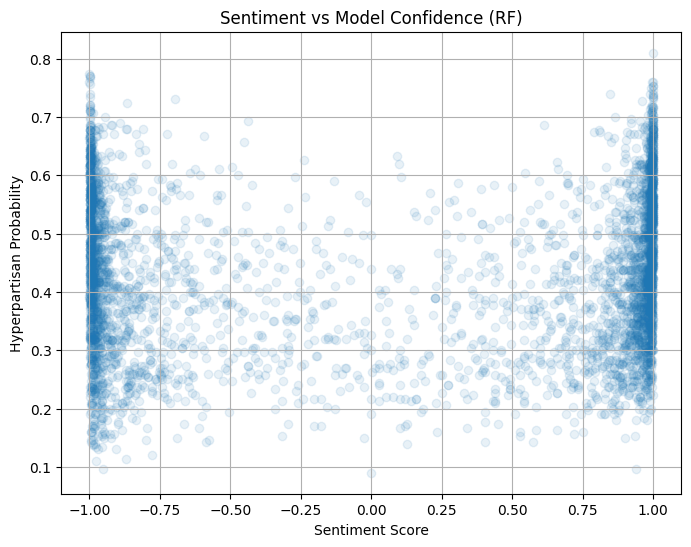

In [40]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

sentiment = test_data['sentiment_score'].values
if len(sentiment) == len(y_pred_proba):
    corr, p = pearsonr(sentiment, y_pred_proba)
    print(f"Pearson Correlation: {corr:.3f} (p = {p:.3f})")

    plt.figure(figsize=(8, 6))
    plt.scatter(sentiment, y_pred_proba, alpha=0.1)
    plt.xlabel("Sentiment Score")
    plt.ylabel("Hyperpartisan Probability")
    plt.title("Sentiment vs Model Confidence (RF)")
    plt.grid(True)
    plt.show()


#Correct vs. Misclassified Comparison

In [41]:
correct_mask = (y_pred == y_test)
incorrect_mask = ~correct_mask
confidence_scores = np.where(y_pred == 1, y_pred_proba, 1 - y_pred_proba)
sentiment_scores = test_data['sentiment_score'].values

print("\nCorrect vs. Misclassified (Random Forest):")
print(f"Correct Predictions: {np.sum(correct_mask)}")
print(f"Misclassified: {np.sum(incorrect_mask)}")
print("-" * 30)
print(f"Avg Confidence (Correct): {np.mean(confidence_scores[correct_mask]):.3f}")
print(f"Avg Confidence (Misclassified): {np.mean(confidence_scores[incorrect_mask]):.3f}")
print("-" * 30)
print(f"Avg Sentiment (Correct): {np.mean(sentiment_scores[correct_mask]):.3f}")
print(f"Avg Sentiment (Misclassified): {np.mean(sentiment_scores[incorrect_mask]):.3f}")
print("-" * 30)
print(f"Avg ABS Sentiment (Correct): {np.mean(np.abs(sentiment_scores[correct_mask])):.3f}")
print(f"Avg ABS Sentiment (Misclassified): {np.mean(np.abs(sentiment_scores[incorrect_mask])):.3f}")



Correct vs. Misclassified (Random Forest):
Correct Predictions: 2055
Misclassified: 1945
------------------------------
Avg Confidence (Correct): 0.632
Avg Confidence (Misclassified): 0.621
------------------------------
Avg Sentiment (Correct): 0.125
Avg Sentiment (Misclassified): 0.066
------------------------------
Avg ABS Sentiment (Correct): 0.870
Avg ABS Sentiment (Misclassified): 0.857


Saving for comparison....



In [ ]:
import joblib
import pandas as pd

# Create a combined dataframe (like RoBERTa's prediction_df)
prediction_df_rf = test_data.copy()
prediction_df_rf["rf_pred"] = y_pred
prediction_df_rf["rf_proba"] = y_pred_proba

# Save everything in a dictionary
rf_results = {
    "y_test": y_test,
    "y_pred": y_pred,
    "y_pred_proba": y_pred_proba,
    "prediction_df": prediction_df_rf,
}

joblib.dump(rf_results, "results/by_publisher_rf_results.pkl")
print("Saved RF predictions and test info to ../results/by_publisher_rf_results.pkl")
